In [69]:
import numpy as np
% tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [70]:
#load the dataset
(training_images, training_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

Training_images shape:  (60000, 28, 28)
How many test samples are there:  10000
Training labels shape:  (60000,)
One label example:  9


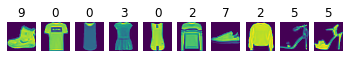

In [71]:
#Visualization
print("Training_images shape: ", training_images.shape)
print("How many test samples are there: ", test_images.shape[0])
print("Training labels shape: ", training_labels.shape)
print("One label example: ", training_labels[0])

#Visualize the images
fig, ax = plt.subplots(1,10)

for i in range(10):
  ax[i].imshow(training_images[i])
  ax[i].set_title(training_labels[i])
  ax[i].axis("off")




## Preprocessing

In [72]:
#perform necessary preprocessing steps
#for our autoencoder we do not need the labels

#normalizing the images
training_images = tf.data.Dataset.from_tensor_slices(training_images)
training_images = training_images.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
training_images = training_images.map(lambda img: img/255)
#labels must be stored as a Dataset to add them to the training_data
#as we do not use them for training no one_hot encoding is needed though
training_labels = tf.data.Dataset.from_tensor_slices(training_labels)

#Prepare the dataset
#this includes dividing the dataset into batches
training_data = tf.data.Dataset.zip((training_images, training_labels))
training_data = training_data.batch(64)
training_data = training_data.shuffle(buffer_size= 64)
training_data = training_data.prefetch(16)

test_images = test_images[:1000]
test_labels = test_labels[:1000]
test_images = tf.data.Dataset.from_tensor_slices(test_images)
test_images = test_images.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
test_images = test_images.map(lambda img: img/255)

test_labels = tf.data.Dataset.from_tensor_slices(test_labels)

test_data = tf.data.Dataset.zip((test_images, test_labels))
test_data = test_data.batch(64)
test_data = test_data.shuffle(buffer_size= 64)
test_data = test_data.prefetch(16)

## 1. Convolutional Autoencoder

### 1.1. Encoder

In [73]:
class EncBlock(tf.keras.layers.Layer):
  def __init__(self, number_filters):
    super(EncBlock, self).__init__()
    self.conv = tf.keras.layers.Conv2D(filters = number_filters, activation = None, kernel_size = 3, padding = 'same')
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.ReLU()
    self.pool = tf.keras.layers.MaxPool2D(strides = (2,2))

  def call(self, input_x, training):
    x = self.conv(input_x)
    x = self.batch_norm(x, training)
    x = self.relu(x)
    x = self.pool(x)

    return x

class Encoder(tf.keras.Model):
  def __init__(self):
    super(Encoder, self).__init__()
    #self.dense_layer = tf.keras.layers.Dense(units = (28*28), activation = tf.keras.activations.relu)
    self.block1 = EncBlock(32)
    self.block2 = EncBlock(16)

    self.flatten = tf.keras.layers.Flatten()
    self.encoding_layer = tf.keras.layers.Dense(units = 10, activation = tf.keras.activations.softmax)

  def call(self, input_x, training):

    x = self.block1(input_x, training)
    x = self.block2(x, training)
    x = self.flatten(x)
    x = self.encoding_layer(x)

    return x


### 1.2. Decoder

In [74]:
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder, self).__init__()
    #firstly restore dimensionality with a dense_layer
    
    self.dense_layer = tf.keras.layers.Dense(units = (7*7*32), activation = tf.keras.activations.relu)
    self.reshape = tf.keras.layers.Reshape((7,7,32))
    self.ConvT_1 = tf.keras.layers.Conv2DTranspose(filters =16, padding = 'same', kernel_size = 3, strides = (2,2))
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.relu1 = tf.keras.layers.ReLU()
    self.ConvT_2 = tf.keras.layers.Conv2DTranspose(filters =16, padding = 'same', kernel_size = 3, strides = (2,2))
    self.batch_norm2 = tf.keras.layers.BatchNormalization()
    self.relu2 = tf.keras.layers.ReLU()
    self.output_layer = tf.keras.layers.Conv2D(filters=1, padding = 'same', kernel_size = 3, activation= tf.keras.activations.sigmoid)

  def call(self, input_x, training):
    x = self.dense_layer(input_x)
    x = self.reshape(x)
    x = self.ConvT_1(x)
    x = self.batch_norm1(x, training)
    x = self.relu1(x)
    x = self.ConvT_2(x)
    x = self.batch_norm2(x, training)
    x = self.relu2(x)
    x = self.output_layer(x)

    return x

### 1.3. Autoencoder

In [75]:
class ConvoAE(tf.keras.Model):
  def __init__(self):
    super(ConvoAE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    
  def call(self, input_x, training):
    x = self.encoder(input_x, training)
    x = self.decoder(x, training)

    return x

2. Variational Autoencoder

## Training

In [76]:
def train_step(model, samples, loss_function, optimizer, training= True):
  with tf.GradientTape() as tape:
    reconstructed_img = model(samples, training)
    loss = loss_function(reconstructed_img, samples)

    gradients = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss

def test(model, input, loss_function, training= False):
  losses = []
  accuracies = []

  for image,label in input:
    reconstructed_img = model(image, training)
    loss = loss_function(reconstructed_img, image)

  return loss


In [77]:
def plot_img(image_rec, image):
  
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(image_rec)
  ax[0].set_title("reconstructed image")
  ax[0].axis("off")
  ax[1].imshow(image)
  ax[1].set_title("input")
  ax[1].axis("off")

In [78]:
def timing(start):
    now = time.time()
    time_per_training_step = now - start
    # compute duration of an epoch
    return round(time_per_training_step, 2)

In [ ]:
tf.keras.backend.clear_session()

# Initialize our models with three blocks each
conv_ae = ConvoAE()

#Define hyperparameters
#How many training epochs do we perform
epochs = 10
#define the learning rate which influences the magnitude with which we update the models parameters
learning_rate = 0.001
#as a loss_function we use CategoricalCrossentropy
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate)

running_average_factor = 0.95


steps = []

for epoch in range(epochs):
  print(epoch, ". epoch --------------------------------------------------------------------------------")
  steps.append(epoch)
  losses = []

  start = time.time()
  original_loss = 0
  for (images,labels) in training_data:
    train_loss = train_step(conv_ae, images, loss_function, optimizer, training = True)

    original_loss = running_average_factor * original_loss + (1-running_average_factor) * train_loss
  losses.append(original_loss)
  
  print(f"the training step took {timing(start)} seconds")
  #some sort of plotting
  print("train_loss", np.mean(losses))

0 . epoch --------------------------------------------------------------------------------


## Latent Space Analysis

In [ ]:
#test_embeddings = test_data[:1000]